In [12]:
import numpy as np
import matplotlib.pyplot as plt
import reservoirpy as rpy
from reservoirpy.datasets import mackey_glass
from numpy import *
import scipy as scp

In [13]:
rng=np.random.default_rng(123456)
rng.normal()

0.19282119546170398

(3000, 1)


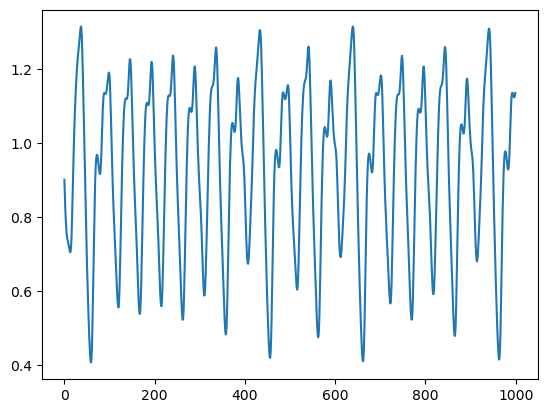

In [124]:

# création de la série 
size=3000
serie = mackey_glass(size, seed=123456)
print(np.shape(serie))
plt.plot(serie[2000:])

In [229]:
entry_dimension=1
nb_neurons=1000 #nombre de neurones dans le reservoir
warmup=100 #nombre d'itérations supprimées du resevoir avant qu'il soit initialisé
spectral_radius=0.98 #rayon spectral de la matrice W 
R_connectivity=0.1 #sparsité du reservoir, connectivité dans le reservoir 
leak_rate=0.1 #indice de fuite du reservoir

#Matrice des poids de la couche d'entrée
W_in=rng.uniform(low=-1,high=1,size=(nb_neurons,entry_dimension)).reshape(nb_neurons,entry_dimension) #*(rng.uniform(size=(1000,1))<0.2)

#Matrice des poids du reservoir
W=rng.normal(loc=0,scale=1,size=(nb_neurons,nb_neurons)) #matrice aléaotoire distribution normale centrée réduite
W=W* (rng.uniform(size=(nb_neurons,nb_neurons))<R_connectivity) #On connecte les neurones selon la connectivité
lamb=np.max(np.abs(linalg.eigvals(W)))
W=W/lamb
W=spectral_radius*W #On decide d'un rayon spectral spécifique a la matrice du reservoir 

#matrice des états du resevoir, pour chaque valeur de la série on calcule les états du reservoir
V = np.zeros((nb_neurons, serie.shape[0]-1))
V[:,0]=rng.uniform(low=-1,high=1,size=(nb_neurons,))  #on initialise aléatoirement le V0, l'etat initial du reservoir


#test du modèle

test_size=int(100) #taille echantillon sur lequel on fait le test
panel= size-test_size #taille echantillon avant le test

In [230]:
# construction de la matrice des états a la sortie du reservoir: 
for i in range(serie.shape[0] - 2):
    # formule de calcul du vecteur d'état du reservoir au temps i 
    x = (W_in * serie[i, 0]) + (W @ V[:, i].reshape(nb_neurons, 1)) 
    x = np.tanh(x)#fonction d'activation
    #calcul du vecteur de sortie du reservoir
    vt1 = (1 - leak_rate) * V[:, i].reshape(nb_neurons, 1) + leak_rate * x 
    vt1[0, 0] = 1 #ajout du biai=1
    V[:, i + 1] = vt1.ravel() #ajout du vecteur de sortie du reservoir a V

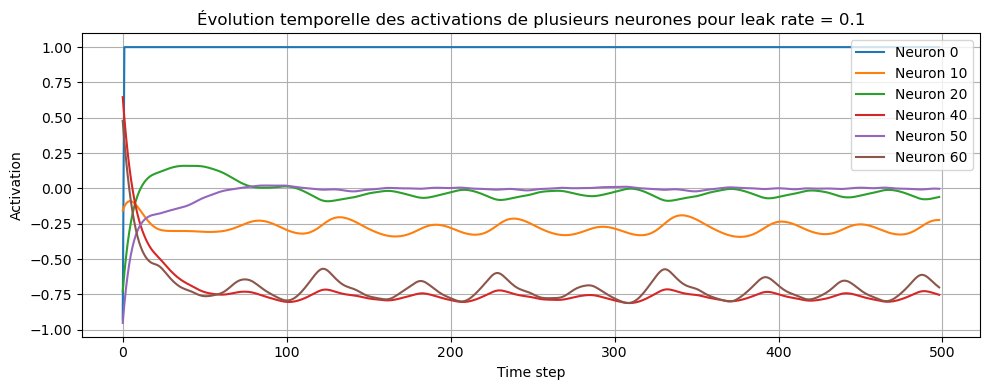

In [231]:
# Sélectionne les indices des neurones à tracer (par exemple les 5 premiers)
neurons_to_plot =[0, 10, 20,40,50, 60]
# Axe temporel
time = np.arange(V.shape[1])  # V.shape[1] = nombre de colonnes = temps

plt.figure(figsize=(10, 4))
for idx in neurons_to_plot:
    plt.plot(time, V[idx, :], label=f'Neuron {idx}')

plt.xlabel('Time step')
plt.ylabel('Activation')
plt.title(f'Évolution temporelle des activations de plusieurs neurones pour leak rate = {leak_rate}')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [232]:
#formule de calcul de la matrice W_out, régularisation de Thikonov
reg = 1e-6 # indice de régularisation
W_out = serie[warmup+1:].reshape(1, -1) @ V[:, warmup:].T @ np.linalg.inv(V[:, warmup:] @ V[:, warmup:].T + reg * np.eye(V.shape[0]))

#W_out/=np.max(W_out)

In [233]:

test_serie = serie[:panel, 0].reshape((panel, 1)) # serie de test
x0 = V[:, (size-test_size)].reshape(nb_neurons, 1)   # état du réservoir au temps "size-test_size"
output = np.zeros((test_size, 1)) #initialisation vecteur de sortie
u0 = test_serie[0, 0]              # première entrée de test

for i in range(test_size):
    x = (1 - leak_rate) * x0 + leak_rate * np.tanh((W_in * u0) + (W @ x0)) # calcul de l'itération de l'etat du modèle au temps i+1
    x[0] = 1  # biais
    output[i, 0] = float(W_out @ x)  # prédiction au temps i+1
    u0 = output[i, 0]  # feedback = nouvelle entrée
    x0 = x  # mise à jour de l’état


/var/folders/6m/nc11lc0140jdsjpbbmvlcw7m0000gn/T/ipykernel_37543/749900230.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  output[i, 0] = float(W_out @ x)  # prédiction au temps i+1


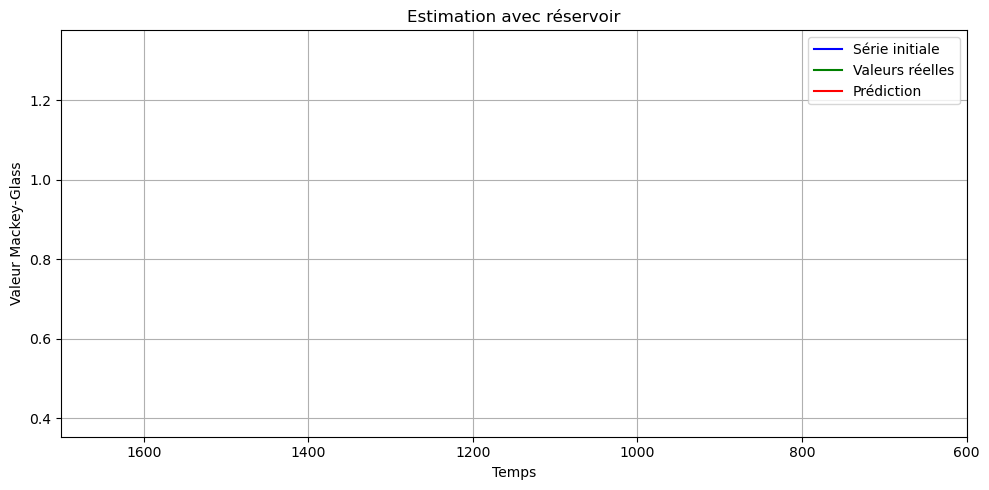

In [234]:
# Découpage
initial_serie = serie[:(size-test_size), 0]
real_values = serie[(size-test_size):, 0]
estimated_values = output[:, 0]  # suppose que output.shape = (len(serie) - 1900, 1)

# Tracés
plt.figure(figsize=(10, 5))

plt.plot(time[:(size-test_size)], initial_serie, label='Série initiale', color='blue')
plt.plot(time[(size-test_size-1):], real_values, label='Valeurs réelles', color='green')
plt.plot(time[(size-test_size-1):], estimated_values, label='Prédiction', color='red')

plt.xlim((1700,size+test_size))
plt.xlabel('Temps')
plt.ylabel('Valeur Mackey-Glass')
plt.title('Estimation avec réservoir')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

/var/folders/6m/nc11lc0140jdsjpbbmvlcw7m0000gn/T/ipykernel_37543/872290904.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Xn1[i, 0] = float(W_out @ X)  # prédiction


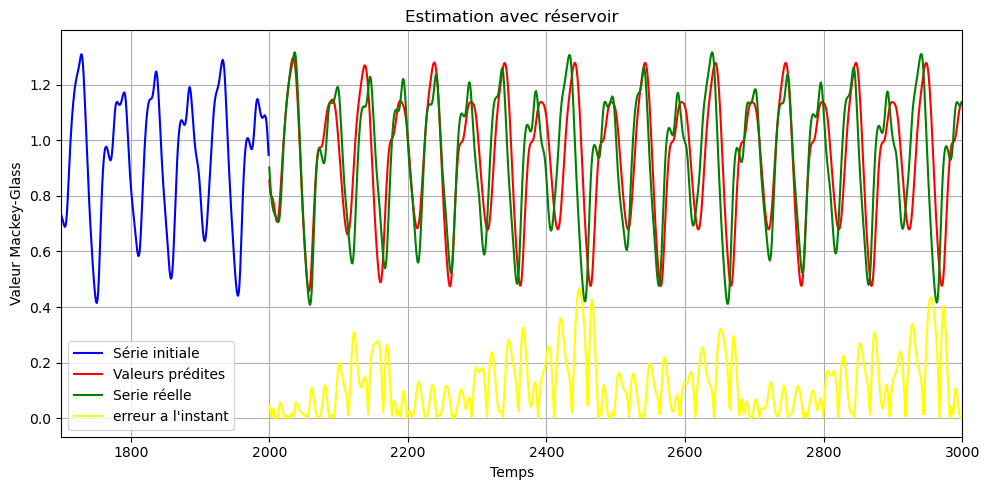

In [215]:
step=1000 #taille de l'echantillon des nouvelles prédictions
Xn = V[:, size-step-1].reshape(nb_neurons, 1)   # état du réservoir au temps 1999
Xn1 = np.zeros((step, 1))
U0 = serie[size-step, 0]              # première entrée de test

for i in range(n):
    X = (1 - leak_rate) * Xn + leak_rate * np.tanh((W_in * U0) + (W @ Xn))
    X[0] = 1  # biais
    Xn1[i, 0] = float(W_out @ X)  # prédiction
    U0 = Xn1[i, 0]  # feedback = nouvelle entrée
    Xn = X  # mise à jour de l’état
Xn2=np.concatenate([serie[:size-step],Xn1])
time = np.arange(Xn2.shape[0])
# Tracés
plt.figure(figsize=(10, 5))

plt.plot(time[:size-step],Xn2[:size-step], label='Série initiale', color='blue')
plt.plot(time[size-step:],Xn2[size-step:], label='Valeurs prédites', color='red')
plt.plot(time[size-step:],serie[size-step:], label='Serie réelle',color='green')
plt.plot(time[size-step:], np.abs(serie[size-step:]-Xn2[size-step:]), label="erreur a l'instant", color='yellow' )
plt.xlim((1700,2000+step))
plt.xlabel('Temps')
plt.ylabel('Valeur Mackey-Glass')
plt.title('Estimation avec réservoir')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [219]:
from itertools import product

# Paramètres
leak_rates = [0.1, 0.3]
spectral_radii = [0.9, 1.1]
connectivities = [0.05, 0.1]
Units = 100  # Pour test rapide
size=500
serie = mackey_glass(size, seed=123456)  # Série aléatoire pour test
size = serie.shape[0]

# Initialisation
results = {}

for leak_rate, sr, conn in product(leak_rates, spectral_radii, connectivities):
    key = (leak_rate, sr, conn)

    # Construction du réservoir
    rng = np.random.default_rng(42)
    W_in = rng.uniform(low=-1, high=1, size=(nb_neurons, 1))
    W = rng.normal(0, 1, size=(nb_neurons, nb_neurons))
    eigvals = np.linalg.eigvals(W)
    W = W / np.abs(eigvals).max() * sr  # Ajuster le rayon spectral
    mask = rng.uniform(0, 1, size=(nb_neurons, nb_neurons)) < conn
    W *= mask  # Appliquer la connectivité

    # Matrice d’états
    V = np.zeros((nb_neurons, size))
    V[:, 0] = rng.normal(0, 1, size=nb_neurons)

    for t in range(1, size):
        x = V[:, t-1].reshape(-1, 1)
        u = serie[t-1, 0]
        x_new = (1 - leak_rate) * x + leak_rate * np.tanh(W_in * u + W @ x)
        x_new[0, 0] = 1  # biais
        V[:, t] = x_new.ravel()

    # Calcul de W_out avec régularisation ridge
    ridge = 1e-6
    V_train = V[:, 100:]  # warm-up
    Y_train = serie[100:, 0].reshape(1, -1)
    W_out = Y_train @ V_train.T @ np.linalg.inv(V_train @ V_train.T + ridge * np.eye(nb_neurons))

    # Stockage
    results[key] = {
        "V": V,
        "W_out": W_out
    }

# Exemple d’accès à un jeu de paramètres
example_key = (0.1, 0.9, 0.05)
example_V = results[example_key]["V"]
example_W_out = results[example_key]["W_out"]

print(f"Matrice V pour {example_key} de forme {example_V.shape}")
print(f"Matrice W_out pour {example_key} de forme {example_W_out.shape}")

Matrice V pour (0.1, 0.9, 0.05) de forme (100, 500)
Matrice W_out pour (0.1, 0.9, 0.05) de forme (1, 100)


In [221]:
results[0.1, 0.9, 0.05]['V']

array([[-0.04546689,  1.        ,  1.        , ...,  1.        ,
         1.        ,  1.        ],
       [ 0.41725447,  0.37371893,  0.33377974, ..., -0.12775159,
        -0.13072347, -0.1334992 ],
       [-0.59693107, -0.46943214, -0.35790767, ...,  0.53340009,
         0.5447511 ,  0.55506093],
       ...,
       [-0.04229287, -0.11896945, -0.18581403, ..., -0.6839815 ,
        -0.69399983, -0.70322436],
       [ 0.31220046,  0.2054756 ,  0.12003653, ..., -0.40954313,
        -0.42334862, -0.43579038],
       [-0.07751778,  0.01234524,  0.09030692, ...,  0.64310658,
         0.65484857,  0.66550905]])

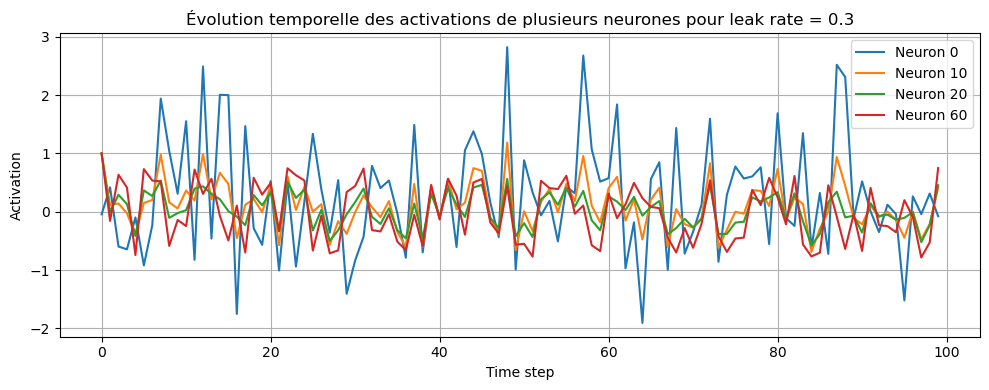

In [226]:
# Sélectionne les indices des neurones à tracer (par exemple les 5 premiers)
neurons_to_plot =[0, 10, 20, 60]
# Axe temporel
time = np.arange(nb_neurons)  # V.shape[1] = nombre de colonnes = temps

plt.figure(figsize=(10, 4))
for idx in neurons_to_plot:
    plt.plot(time, results[0.1, 0.9, 0.05]['V'][:,idx], label=f'Neuron {idx}')

plt.xlabel('Time step')
plt.ylabel('Activation')
plt.title(f'Évolution temporelle des activations de plusieurs neurones pour leak rate = {leak_rate}')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()